In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV filcondae I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import matplotlib.pyplot as plt
import lightgbm as lgb
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns # for prettier plots
import plotly.express as px
import datetime
import lightgbm as lgb


Mounted at /content/drive


# 목표
- 2013년 1월 ~ 2015년 10월 정보로 2015년 11월 세일즈를 구한다.

In [114]:
item_categories = pd.read_csv('/content/drive/MyDrive/KAGGLE/store sales/store data/item_categories.csv')
items = pd.read_csv('/content/drive/MyDrive/KAGGLE/store sales/store data/items.csv')
sales_train = pd.read_csv('/content/drive/MyDrive/KAGGLE/store sales/store data/sales_train.csv')
shops = pd.read_csv('/content/drive/MyDrive/KAGGLE/store sales/store data/shops.csv')

In [115]:
sales_train = sales_train.sort_values(by = ['date','shop_id']).reset_index(drop = True)

In [116]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,01.01.2013,0,2,11828,1699.0,1.0
1,01.01.2013,0,2,12134,299.0,1.0
2,01.01.2013,0,2,6916,999.5,1.0
3,01.01.2013,0,2,8665,299.0,1.0
4,01.01.2013,0,2,8712,198.0,1.0
...,...,...,...,...,...,...
2935844,31.12.2014,23,59,20949,5.0,5.0
2935845,31.12.2014,23,59,21762,1499.0,1.0
2935846,31.12.2014,23,59,20404,2399.0,1.0
2935847,31.12.2014,23,59,20610,1099.0,1.0


In [117]:
sales_train['date'] = pd.to_datetime(sales_train['date'])
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [118]:
sales_train.isna().sum().sum()
### 결측치 없다

0

In [119]:
### test도 불러오기
test = pd.read_csv('/content/drive/MyDrive/KAGGLE/store sales/store data/test.csv')
test = test.sort_values(by = ['shop_id', 'item_id']).reset_index(drop = True)
test

,ID,shop_id,item_id
0,22987,2,30
1,20994,2,31
2,20995,2,32
3,22492,2,33
4,22491,2,38
...,...,...,...
214195,149575,59,22162
214196,148799,59,22163
214197,149242,59,22164
214198,152328,59,22166


### 몇개 데이터에 대해서 살펴보기

In [120]:
sales_train[(sales_train['shop_id'] == 2) & (sales_train['item_id'] == 6916)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-01-01,0,2,6916,999.50,1.0
185000,2013-02-11,10,2,6916,1499.00,1.0
260387,2013-03-08,7,2,6916,936.97,1.0
355625,2013-04-08,7,2,6916,749.50,2.0
517124,2013-06-04,3,2,6916,1049.00,1.0
527457,2013-06-05,4,2,6916,749.00,1.0
549098,2013-06-08,7,2,6916,749.50,1.0
730028,2013-08-05,4,2,6916,749.50,1.0
944957,2013-10-09,8,2,6916,899.88,1.0
1059666,2013-12-01,0,2,6916,1999.00,1.0


In [121]:
sales_train[sales_train['date'].dt.year == 2015]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
3521,2015-01-01,24,2,7020,1999.0,1.0
3522,2015-01-01,24,2,7893,2490.0,1.0
3523,2015-01-01,24,2,5038,2999.0,1.0
3524,2015-01-01,24,2,6183,1999.0,1.0
3525,2015-01-01,24,2,5672,3590.0,1.0
...,...,...,...,...,...,...
2919732,2015-10-31,33,59,4181,1290.0,1.0
2919733,2015-10-31,33,59,4719,999.0,1.0
2919734,2015-10-31,33,59,5065,229.0,1.0
2919735,2015-10-31,33,59,5811,98.0,1.0


In [122]:
### 이렇게 date_block_num이 틀린 애들이 많다. 고쳐주자
sales_train[(sales_train['shop_id'] == 0) & (sales_train['item_id'] == 32) & (sales_train['date_block_num'] == 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
197884,2013-03-01,0,0,32,221.0,2.0
1895381,2013-01-21,0,0,32,221.0,2.0
2291634,2013-01-25,0,0,32,221.0,1.0
2868322,2013-01-31,0,0,32,221.0,1.0


# 1. 전처리

### 1-1 Date Block Num 틀린거 고쳐주기

In [123]:
sales_train['date_block_num'] = (sales_train['date'].dt.year - 2013) * 12 + sales_train['date'].dt.month - 1

### 1-2 Outlier 정리하기

In [124]:
sales_train = sales_train[(sales_train['item_price']<=50000) & (sales_train['item_price']>=0)]
sales_train = sales_train[(sales_train['item_cnt_day']<=1001) & (sales_train['item_cnt_day']>=0)]
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,0,2,11828,1699.0,1.0
1,2013-01-01,0,2,12134,299.0,1.0
2,2013-01-01,0,2,6916,999.5,1.0
3,2013-01-01,0,2,8665,299.0,1.0
4,2013-01-01,0,2,8712,198.0,1.0
...,...,...,...,...,...,...
2935844,2014-12-31,23,59,20949,5.0,5.0
2935845,2014-12-31,23,59,21762,1499.0,1.0
2935846,2014-12-31,23,59,20404,2399.0,1.0
2935847,2014-12-31,23,59,20610,1099.0,1.0


### 1-3 shop_id 정리

In [125]:
#  Modify shop_id in sales_train data
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

In [126]:
#  Modify shop_id in test data
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

### 1-4 city와 item category 정보 뽑아내기

In [127]:
### shop name에서 city 정보를 뽑아낸다.
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

In [128]:
from sklearn.preprocessing import LabelEncoder

### city에 대해서 label encoding 진행
# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])
shops = shops[['shop_id','city']]

In [129]:
### item category 이름에서 category 정리하기
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split()[0]) 
# category에 대해서 label encoding 진행
item_categories['category'] = label_encoder.fit_transform(item_categories['category'])
item_categories = item_categories[['item_category_id','category']]

In [130]:
### item이랑 item_category 합치기
df_item = pd.merge(items, item_categories, on = 'item_category_id',how = 'left')
df_item = df_item.drop(columns = ['item_name'])
df_item

,item_id,item_category_id,category
0,0,40,7
1,1,76,11
2,2,40,7
3,3,40,7
4,4,40,7
...,...,...,...
22165,22165,31,5
22166,22166,54,8
22167,22167,49,8
22168,22168,62,10


### 최종 : city, item category 정보 합치기

In [131]:
### train에 합치기
sales_train = pd.merge(sales_train, shops, on = 'shop_id', how = 'left')
sales_train = pd.merge(sales_train, df_item, on = 'item_id', how = 'left')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,city,item_category_id,category
0,2013-01-01,0,2,11828,1699.0,1.0,0,22,5
1,2013-01-01,0,2,12134,299.0,1.0,0,30,5
2,2013-01-01,0,2,6916,999.5,1.0,0,19,5
3,2013-01-01,0,2,8665,299.0,1.0,0,40,7
4,2013-01-01,0,2,8712,198.0,1.0,0,40,7


In [132]:
### test에 합치기
test = pd.merge(test, shops, on = 'shop_id', how = 'left')
test = pd.merge(test, df_item, on = 'item_id', how = 'left')
test.head()

,ID,shop_id,item_id,city,item_category_id,category
0,22987,2,30,0,40,7
1,20994,2,31,0,37,7
2,20995,2,32,0,40,7
3,22492,2,33,0,37,7
4,22491,2,38,0,41,7


In [133]:
### test의 date_block_num에 34 넣어주기
test['date_block_num'] = 34
### test의 ID 떼어주기
test = test.drop(columns = ['ID'])
test

,shop_id,item_id,city,item_category_id,category,date_block_num
0,2,30,0,40,7,34
1,2,31,0,37,7,34
2,2,32,0,40,7,34
3,2,33,0,37,7,34
4,2,38,0,41,7,34
...,...,...,...,...,...,...
214195,59,22162,30,40,7,34
214196,59,22163,30,40,7,34
214197,59,22164,30,37,7,34
214198,59,22166,30,54,8,34


# 2. Feature Engineering
### 2-1 Monthly data 추가하기
1. item_cnt_month : item_cnt_day를 각 달별, 아이템별로 sum해준다.
2. sales_month : item_cnt_day * item_price를 해줘서 각 달별, 아이템별 총 판매 금액을 구해준다.
3. item_count : 각 달별, item별 팔린 횟수를 체크한다.

In [134]:
### 각 월별로 monthly data 추가하기
sales_train['sales'] = sales_train['item_cnt_day'] * sales_train['item_price']
monthly_sales = sales_train.groupby(['date_block_num','shop_id','item_id']).sum().reset_index().rename(columns = {'item_cnt_day':'item_cnt_month','sales':'sales_month'})
monthly_item_count = sales_train.groupby(['date_block_num','shop_id','item_id']).count().reset_index().rename(columns = {'item_cnt_day':'item_count'})

### sales_train에 merge해주기
monthly_sales_train = pd.merge(sales_train, monthly_sales[['date_block_num','shop_id','item_id','item_cnt_month','sales_month']], on = ['date_block_num','shop_id','item_id'])
monthly_sales_train = pd.merge(monthly_sales_train, monthly_item_count[['date_block_num','shop_id','item_id','item_count']], on = ['date_block_num','shop_id','item_id'])
monthly_sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,city,item_category_id,category,sales,item_cnt_month,sales_month,item_count
0,2013-01-01,0,2,11828,1699.0,1.0,0,22,5,1699.0,2.0,2328.3,2
1,2013-01-06,0,2,11828,629.3,1.0,0,22,5,629.3,2.0,2328.3,2
2,2013-01-01,0,2,12134,299.0,1.0,0,30,5,299.0,5.0,1495.0,5
3,2013-01-04,0,2,12134,299.0,1.0,0,30,5,299.0,5.0,1495.0,5
4,2013-01-10,0,2,12134,299.0,1.0,0,30,5,299.0,5.0,1495.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928483,2014-12-31,23,59,14446,399.0,1.0,30,40,7,399.0,1.0,399.0,1
2928484,2014-12-31,23,59,14432,149.0,1.0,30,40,7,149.0,1.0,149.0,1
2928485,2014-12-31,23,59,14457,149.0,1.0,30,40,7,149.0,1.0,149.0,1
2928486,2014-12-31,23,59,14147,299.0,1.0,30,55,9,299.0,1.0,299.0,1


In [135]:
### monthly item count와 monthly sales만 남긴다.
monthly_sales_train = monthly_sales_train.drop(columns = ['date','item_price','item_cnt_day','sales']).drop_duplicates().reset_index(drop = True)
monthly_sales_train

,date_block_num,shop_id,item_id,city,item_category_id,category,item_cnt_month,sales_month,item_count
0,0,2,11828,0,22,5,2.0,2328.3,2
1,0,2,12134,0,30,5,5.0,1495.0,5
2,0,2,6916,0,19,5,1.0,999.5,1
3,0,2,8665,0,40,7,1.0,299.0,1
4,0,2,8712,0,40,7,1.0,198.0,1
...,...,...,...,...,...,...,...,...,...
1792461,23,59,14446,30,40,7,1.0,399.0,1
1792462,23,59,14432,30,40,7,1.0,149.0,1
1792463,23,59,14457,30,40,7,1.0,149.0,1
1792464,23,59,14147,30,55,9,1.0,299.0,1


### 각 shop 별 제품이 몇달동안 등장하는지?

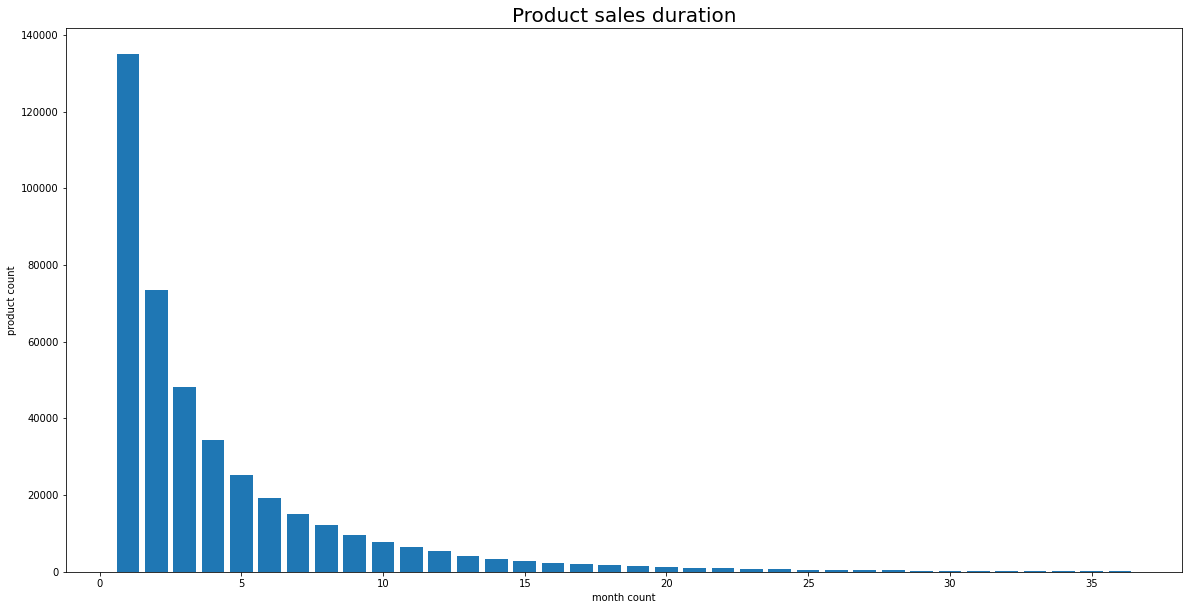

In [136]:
### 각 제품이 몇 달동안 팔리는지 구하기
monthly_count = sales_train[['date_block_num','shop_id','item_id']].drop_duplicates().groupby(['shop_id','item_id']).count().reset_index()[['date_block_num','shop_id']]
monthly_count_df = monthly_count.groupby(['date_block_num']).count()

### 그래프로 시각화
plt.figure(figsize = (20,10))
plt.bar(monthly_count_df.index, monthly_count_df['shop_id'])
plt.xlabel('month count')
plt.ylabel('product count')
plt.title('Product sales duration', size = 20)
plt.show()

### 1달동안 팔린 제품이 압도적으로 많고 10달 이상 팔린 제품이 없는 것을 보면 시계열을 적용하기가 힘들 것 같다는 생각
### 그렇다면 머신러닝으로 접근해야 할 듯 하다

# 3. Lag Features
### 1. Mean Feature 만들기

몇개의 feature을 조합해서 monthly로 item count를 구한다.

In [137]:
def mean_features(idx_features):

    # train_df 생성
    train_df = monthly_sales_train.copy()

    # idx_features 안에 feature 요소가 2개 이상일 때 조합해서 새로운 mean feature 생성
    for idx in idx_features:
        idx.insert(0,'date_block_num')
        if len(idx) >=2:
            feature_name = ''
            for i in idx[1:]:
                feature_name += i+'_'
            feature_name += 'mean_cnt'
            one_df = train_df.groupby(idx).agg({'item_cnt_month':'mean'}).reset_index()
            one_df = one_df.rename(columns={'item_cnt_month': feature_name})
        train_df = pd.merge(train_df, one_df, on = idx, how = 'left')

    return train_df

In [138]:
### mean feature 만들기
train_df = mean_features([['item_id'],['item_id','city'],['shop_id'],['category'],['shop_id','category']])
train_df = train_df[train_df['date_block_num']<=33] #date_block_num이 34 이상인 item들이 보여서 이상치로 판단 후 제거
train_df

,date_block_num,shop_id,item_id,city,item_category_id,category,item_cnt_month,sales_month,item_count,item_id_mean_cnt,item_id_city_mean_cnt,shop_id_mean_cnt,category_mean_cnt,shop_id_category_mean_cnt
0,0,2,11828,0,22,5,2.0,2328.3,2,1.818182,2.0,1.341071,2.318756,1.419913
1,0,2,12134,0,30,5,5.0,1495.0,5,4.547619,5.0,1.341071,2.318756,1.419913
2,0,2,6916,0,19,5,1.0,999.5,1,3.351351,1.0,1.341071,2.318756,1.419913
3,0,2,8665,0,40,7,1.0,299.0,1,1.750000,1.0,1.341071,1.550751,1.053333
4,0,2,8712,0,40,7,1.0,198.0,1,1.000000,1.0,1.341071,1.550751,1.053333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792461,23,59,14446,30,40,7,1.0,399.0,1,4.090909,1.0,1.949564,1.697949,1.207018
1792462,23,59,14432,30,40,7,1.0,149.0,1,1.285714,1.0,1.949564,1.697949,1.207018
1792463,23,59,14457,30,40,7,1.0,149.0,1,1.916667,1.0,1.949564,1.697949,1.207018
1792464,23,59,14147,30,55,9,1.0,299.0,1,1.428571,1.0,1.949564,1.521704,1.210145


### 2. Lag feature 만들기

In [144]:
### Lag feature 만들기
def add_lag_features(df, idx_features, lag_features, nlags=3): 

    for lag_feature in lag_features:
        df_temp = df[idx_features + [lag_feature]].copy()
        for i in range(1, nlags+1):
            lag_feature_name = lag_feature +'_lag' + str(i)
            df_temp.columns = idx_features + [lag_feature_name]
            df_temp['date_block_num'] += 1
            df = df.merge(df_temp.drop_duplicates(), 
                        on=idx_features, 
                        how='left')
            df[lag_feature_name] = df[lag_feature_name].fillna(0)
        if lag_feature != 'item_cnt_month':
            df = df.drop(columns = [lag_feature])
    return df[df['date_block_num'] >= nlags]

In [145]:
idx_features = ['date_block_num', 'shop_id', 'item_id']

# 3달의 lag를 주는 feature들을 만들어본다.
all_data = add_lag_features(pd.concat([train_df, test]).fillna(0),
                     idx_features,
                     ['item_cnt_month','item_count','sales_month','item_id_mean_cnt','item_id_city_mean_cnt','shop_id_mean_cnt','category_mean_cnt','shop_id_category_mean_cnt'], 
                     nlags=3)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1773662 entries, 1663 to 1973799
Data columns (total 31 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   date_block_num                  int64  
 1   shop_id                         int64  
 2   item_id                         int64  
 3   city                            int64  
 4   item_category_id                int64  
 5   category                        int64  
 6   item_cnt_month                  float64
 7   item_cnt_month_lag1             float64
 8   item_cnt_month_lag2             float64
 9   item_cnt_month_lag3             float64
 10  item_count_lag1                 float64
 11  item_count_lag2                 float64
 12  item_count_lag3                 float64
 13  sales_month_lag1                float64
 14  sales_month_lag2                float64
 15  sales_month_lag3                float64
 16  item_id_mean_cnt_lag1           float64
 17  item_id_mean_cnt_lag2   

In [146]:
### Clip 진행 (값을 0~20 사이에 맞추기)
lag_features_to_clip = ['item_cnt_month_lag' + str(i) for i in range(1,4)]
all_data[lag_features_to_clip + ['item_cnt_month']] = all_data[lag_features_to_clip +['item_cnt_month']].clip(0, 20)

# 4. ML 돌려주기
LGBM을 통해 예측 진행

In [147]:
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

In [148]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 256,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

cat_features = ['shop_id', 'city', 'item_category_id', 'category']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=2400,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=200,
                      categorical_feature=cat_features,
                      verbose_eval=100)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category', 'city', 'item_category_id', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.9322	valid_1's rmse: 1.82117
[200]	training's rmse: 1.77515	valid_1's rmse: 1.71169
[300]	training's rmse: 1.69506	valid_1's rmse: 1.66675
[400]	training's rmse: 1.6468	valid_1's rmse: 1.64896
[500]	training's rmse: 1.61211	valid_1's rmse: 1.64214
[600]	training's rmse: 1.58503	valid_1's rmse: 1.64082
[700]	training's rmse: 1.56369	valid_1's rmse: 1.63833
[800]	training's rmse: 1.54435	valid_1's rmse: 1.63756
[900]	training's rmse: 1.52694	valid_1's rmse: 1.6379
[1000]	training's rmse: 1.51196	valid_1's rmse: 1.63965
Early stopping, best iteration is:
[850]	training's rmse: 1.53597	valid_1's rmse: 1.63692


### Submission

In [151]:
preds = lgb_model.predict(X_test).clip(0,20)

#submit
submission = pd.read_csv('/content/drive/MyDrive/KAGGLE/store sales/store data/sample_submission.csv')
submission['item_cnt_month'] = preds
submission.to_csv('/content/drive/MyDrive/KAGGLE/store sales/submission_1129.csv', index=False)